In [ ]:
    """
    Plot a curve and the line tangent to that curve at (p,f(p)),
    with an arrow marking the direction of steepest descent
    
    Parameters:
    -----------
    f: function describing curve to plot
    df_dx: derivative of f with respect to x
    p: x coordinate of tangent line point
    x_range: x axis values to plot, should be symmetric about 0    
    """

In [23]:
import requests
import time
import pickle
import io
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import *  # be more specific
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, LassoCV, ElasticNetCV,ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import cross_val_score, train_test_split, KFold 
from geopy.geocoders import Nominatim

from sklearn.preprocessing import FunctionTransformer, StandardScaler, PolynomialFeatures
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn_pandas import DataFrameMapper

## Load data

In [24]:
# Unpickle data  
with open('df2.pkl', 'rb') as f:
    df2 = pickle.load(f)

In [25]:
df2.columns

Index(['property_id', 'price', 'guests', 'bedrooms', 'beds', 'baths',
       'latitude', 'longitude', 'review_rate', 'review_num', 'property_type',
       'link', 'price_log', 'bedrooms_inc', 'property_type_inc',
       'Entire apartment', 'Entire guest suite', 'Entire house',
       'Private room in apartment', 'Private room in house', 'coordinates',
       'address'],
      dtype='object')

In [5]:
# Unpickle data  
with open('df_raw.pkl', 'rb') as f:
    df_raw = pickle.load(f)

In [26]:
# Make a copy of df to work with
df = df_raw.copy()

NameError: name 'df_raw' is not defined

In [7]:
df.head()

,property_id,price,guests,bedrooms,beds,baths,latitude,longitude,review_rate,review_num,property_type,link
0,14902204,NaN,NaN,Amenities,NaN,NaN,NaN,NaN,4.99,NaN,Explore all 17 photos,https://www.airbnb.com/rooms/plus/14902204?loc...
1,19695953,80.0,6.0,2,3.0,1.0,47.54319,-122.39513,4.95,201.0,Entire home,https://www.airbnb.com/rooms/19695953?location...
2,20212882,149.0,8.0,3,3.0,2.5,47.61843,-122.31352,4.91,172.0,Entire townhouse,https://www.airbnb.com/rooms/20212882?location...
3,14610580,90.0,4.0,Studio,2.0,1.0,47.61730,-122.34565,4.63,240.0,Entire condominium,https://www.airbnb.com/rooms/14610580?location...
4,21951075,NaN,NaN,Amenities,NaN,NaN,NaN,NaN,4.93,NaN,Explore all 19 photos,https://www.airbnb.com/rooms/plus/21951075?loc...


In [8]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 12 columns):
property_id      1636 non-null object
price            1519 non-null float64
guests           1506 non-null float64
bedrooms         1634 non-null object
beds             1525 non-null float64
baths            1514 non-null float64
latitude         1525 non-null float64
longitude        1525 non-null float64
review_rate      1491 non-null float64
review_num       1383 non-null float64
property_type    1634 non-null object
link             1636 non-null object
dtypes: float64(8), object(4)
memory usage: 153.5+ KB


(1636, 12)

## Clean data

In [9]:
# Remove NaN
df1 = df.dropna()
df1.shape

(1353, 12)

In [10]:
# Remove > 4 values for the number of baths (`baths`)
df1['baths'].value_counts()
df1.loc[df['baths'] > 4] = np.nan
df1.dropna(inplace=True)
df1.shape

/Users/greenapple/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/greenapple/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(1349, 12)

In [11]:
# Remove > 7 values for the number of beds (`baths`)
df1['beds'].value_counts()
df1.loc[df['beds'] > 7] = np.nan
# df1.loc[df['beds'] == 0] = np.nan
df1.dropna(inplace=True)
df1.shape

/Users/greenapple/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(1343, 12)

## Incode features and tranform target

In [12]:
# Transform target values -  log(price)
df1['price_log'] = df['price'].apply(lambda x: math.log10(x))

/Users/greenapple/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
# Incode `bedrooms` => `bedrooms_inc`
df1['bedrooms_inc'] = df1['bedrooms']
df1['bedrooms_inc'].value_counts()
df1['bedrooms_inc'].replace(['Studio'], '0.5', inplace=True) # what should be a velue for 'Studio'? 1.5?
df1['bedrooms_inc'] = df1['bedrooms_inc'].astype('float64') 

/Users/greenapple/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/greenapple/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/greenapple/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [14]:
# Incode `property_type` => `property_type_inc`
df1['property_type_inc'] = df1['property_type']
df1['property_type_inc'].replace(['Entire home', 'Entire cottage', 'Entire bungalow', 
                                  'Entire guesthouse', 'Entire townhouse', 'Entire place'], 
                                 'Entire house', inplace=True)
df1['property_type_inc'].replace('Entire condominium', 'Entire apartment', inplace=True) 
df1['property_type_inc'].replace('Private room in condominium', 'Private room in apartment', inplace=True) 

df1['property_type_inc'].replace(['Private room in townhouse', 'Private room in bungalow', 
                                  'Private room in cottage', 'Private room in loft', 
                                  'Private room in guest suite'], 
                                 'Private room in house', inplace=True) 

df1['property_type_inc'].replace('Room in serviced apartment', 'Private room in apartment', inplace=True) 
df1['property_type_inc'].replace('Entire loft', 'Entire guest suite', inplace=True) 

df1['property_type_inc'].replace('Entire loft', 'Entire guest suite', inplace=True) 


/Users/greenapple/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
df1['property_type_inc'].value_counts()

Entire house                         716
Private room in house                243
Entire apartment                     221
Entire guest suite                    95
Private room in apartment             40
Tiny house                             4
Private room in bed and breakfast      3
Entire serviced apartment              2
Private room in guesthouse             2
Camper/RV                              2
Houseboat                              2
Boat                                   1
Entire cabin                           1
Shared room in townhouse               1
Room in bed and breakfast              1
Private room in tent                   1
Room in aparthotel                     1
Room in boutique hotel                 1
Entire villa                           1
Shared room in condominium             1
Entire floor                           1
Shared room in house                   1
Shared room in apartment               1
Shared room                            1
Name: property_t

In [16]:
# Keep most common property types
prop_list = [
    'Entire house', 
    'Private room in house',
    'Entire apartment',
    'Entire guest suite', 
    'Private room in apartment'
]
df2 = df1[df1['property_type_inc'].isin(prop_list)]

## Address feature

In [27]:
df2['coordinates'] = df2.agg('{0[latitude]} , {0[longitude]}'.format, axis=1)

In [28]:
df2.reset_index(inplace=True, drop=True)

In [29]:
def f(coordinates):
    time.sleep(4)
    try:
        geolocator = Nominatim(user_agent="appy")
        location = geolocator.reverse(coordinates)
        address = location.address
    except:
        pass
        address = np.nan
    return address

In [20]:
# Do not run, get pickled data
df2['address'] = df2['coordinates'].map(f)

KeyboardInterrupt: 

In [21]:
# pickled df2 with address data

In [28]:
# Unpickle data  
with open('df2.pkl', 'rb') as f:
    df2 = pickle.load(f)

In [46]:
# Unpickle data REMOVE  
with open('df3.pkl', 'rb') as f:
    df2 = pickle.load(f)

In [47]:
def find_hood(data_point):
    """
    Returns neighborhood based on address and neighborhood dictionary supplied
    
    Parameters:
    -----------
    data_point: a string with address info, coma separated

    """ 
    hood = 'not_found'
    for el in data_point.split(','):
        if hood != 'not_found':
            break
        for key, value in location_dict.items():
            if el.strip().lower() in value:
                hood = key
                break
    return hood               

In [48]:
# Seattle neighborhood library
location_dict = {
    'downtown':['yesler terrace', 'central business distric','belltown', 'central watewrfront', 
                'denny triangle', 'international district', 'pike-market', 'pioneer square',
               'yesler terrace', 'downtown', 'central business district', 'first hill', 
                'international district/chinatown', 'chinatown', 'international district'],
    'ballard':['ballard', 'adams', 'loyal heights', 'sunset hill', 'west woodland', 'whittier heights'],
    'beacon hill':['beacon hill', 'north beacon hill', 'south beacon hill', 'van asselt', 
                   'mid meacon hill', 'holly park'],
    'capitol hill':['capitol hill', 'broadway', 'portage bay', 'Roanoke', 'stevens', 'pike-pine corridor',
                    'madison park', 'montlake', 'interlaken', 'renton hill', 'madison valley'],
    'central district':['central district'],
    'central seattle':['central seattle'],
    'delridge':['delridge'],
    'lake city':['lake city', 'cedar park', 'matthews beach', 'olympic hills', 'meadowbrook', 'victory heights'],
    'lake union':['lake union', 'south lake union', 'westlake', 'eastlake'],
    'magnolia':['magnolia'],
    'university district':['university village', 'ravenna', 'university district', 'laurelhurst', 'northlake'],
    'south end':['south end', 'georgetown', 'south park', 'rainier valley', 'cascade', 'seward park',
                'industrial district'],
    'west seattle':['west seattle', 'alki point', 'arbor heights', 'fairmount park', 'gatewood', 'genesee',
                   'alaska junction', 'west seattle junction', 'admiral district', 'seaview', 
                    'mee-kwa-mooks', 'north admiral'],
    'queen anne':['queen anne', 'lower queen anne', 'west queen anne', 'west queen anne', 'north queen anne'],
    'rainier valley':['columbia city', 'rainier valley', 'brighton', 'dunlap', 'othello', 'mount baker',
                     'rainier beach', 'atlantic city beach', 'rainier view', 'lakeridge', 'hillman city'],
    'northgate':['northgate', 'north gate', 'haller lake', 'maple leaf', 'north college park', 'licton springs',
                 'pinehurst'],
    'north seattle':['broadview', 'bitter lake', 'north beach', 'blue ridge', 'crown hill', 'greenwood',
                    'roosevelt', 'wedgwood', 'view ridge', 'sand point', 'roosevelt', 'bryant', 'wallingford'],
    'phinney ridge':['phinney ridge'],
    'fremont':['fremont'],
    'green lake':['green lake'],
    'burien':['burien', 'central burien'],
    'central district':['central area', 'central district', 'madrona', 'atlantic', 'mann', 'minor', 'leschi'],
    'white center':['white center'],
    'shoreline':['shoreline'],
    'tukwila':['tukwila']
  
}

In [49]:
df2.dropna(inplace=True)
df2.shape
df2

,property_id,price,guests,bedrooms,beds,baths,latitude,longitude,review_rate,review_num,...,property_type_inc,Entire apartment,Entire guest suite,Entire house,Private room in apartment,Private room in house,coordinates,address,hood,zip
0,19695953,80.0,6.0,2,3.0,1.0,47.54319,-122.39513,4.95,201.0,...,Entire house,0,0,1,0,0,"47.54319 , -122.39513","6562, 49th Avenue Southwest, Morgan Junction, ...",west seattle,98136.0
1,20212882,149.0,8.0,3,3.0,2.5,47.61843,-122.31352,4.91,172.0,...,Entire house,0,0,1,0,0,"47.61843 , -122.31352","1415, East Denny Way, Capitol Hill, Seattle, K...",capitol hill,98122.0
2,14610580,90.0,4.0,Studio,2.0,1.0,47.61730,-122.34565,4.63,240.0,...,Entire apartment,1,0,0,0,0,"47.6173 , -122.34565","The Devonshire, 420, Wall Street, South Lake U...",lake union,98121.0
3,12568656,125.0,6.0,1,3.0,1.0,47.63500,-122.34000,4.65,301.0,...,Entire house,0,0,1,0,0,"47.635 , -122.34","Lake Union, Westlake Cycle Track, Westlake, Se...",lake union,98109.0
4,20978960,69.0,4.0,2,2.0,1.0,47.55526,-122.31354,4.88,187.0,...,Entire house,0,0,1,0,0,"47.55526 , -122.31354","5213, 15th Avenue South, Beacon Hill, Seattle,...",beacon hill,98108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,20034739,69.0,2.0,1,2.0,2.0,47.66782,-122.36290,4.63,24.0,...,Private room in house,0,0,0,0,1,"47.66782 , -122.3629","5316, 6th Avenue Northwest, Phinney Ridge, Sea...",phinney ridge,98107.0
1311,24635846,75.0,2.0,1,1.0,1.0,47.61917,-122.31637,4.93,130.0,...,Private room in house,0,0,0,0,1,"47.61917 , -122.31637","108, 12th Avenue East, Eastlake, Capitol Hill,...",lake union,98102.0
1312,11785399,48.0,2.0,1,1.0,1.0,47.60300,-122.30900,4.88,129.0,...,Private room in house,0,0,0,0,1,"47.603 , -122.309","161, 18th Avenue, Central District, Seattle, K...",central district,98122.0
1313,29387201,42.0,2.0,1,1.0,2.0,47.70400,-122.30492,4.57,14.0,...,Private room in house,0,0,0,0,1,"47.704 , -122.30492","2044, Northeast 104th Street, Wedgwood, Northg...",north seattle,98125.0


In [50]:
df2['hood'] = df2['address'].map(find_hood)

In [51]:
df2.loc[df2['hood']=='not_found', 'hood'] = np.nan

In [52]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1235 entries, 0 to 1314
Data columns (total 24 columns):
property_id                  1235 non-null object
price                        1235 non-null float64
guests                       1235 non-null float64
bedrooms                     1235 non-null object
beds                         1235 non-null float64
baths                        1235 non-null float64
latitude                     1235 non-null float64
longitude                    1235 non-null float64
review_rate                  1235 non-null float64
review_num                   1235 non-null float64
property_type                1235 non-null object
link                         1235 non-null object
price_log                    1235 non-null float64
bedrooms_inc                 1235 non-null float64
property_type_inc            1235 non-null object
Entire apartment             1235 non-null uint8
Entire guest suite           1235 non-null uint8
Entire house                 1235 n

In [53]:
df2.dropna(inplace=True)

In [54]:
df2.shape

(1235, 24)

In [ ]:
# Unpickle data  
with open('df_raw.pkl', 'rb') as f:
    df_raw = pickle.load(f)

In [55]:
df2

,property_id,price,guests,bedrooms,beds,baths,latitude,longitude,review_rate,review_num,...,property_type_inc,Entire apartment,Entire guest suite,Entire house,Private room in apartment,Private room in house,coordinates,address,hood,zip
0,19695953,80.0,6.0,2,3.0,1.0,47.54319,-122.39513,4.95,201.0,...,Entire house,0,0,1,0,0,"47.54319 , -122.39513","6562, 49th Avenue Southwest, Morgan Junction, ...",west seattle,98136.0
1,20212882,149.0,8.0,3,3.0,2.5,47.61843,-122.31352,4.91,172.0,...,Entire house,0,0,1,0,0,"47.61843 , -122.31352","1415, East Denny Way, Capitol Hill, Seattle, K...",capitol hill,98122.0
2,14610580,90.0,4.0,Studio,2.0,1.0,47.61730,-122.34565,4.63,240.0,...,Entire apartment,1,0,0,0,0,"47.6173 , -122.34565","The Devonshire, 420, Wall Street, South Lake U...",lake union,98121.0
3,12568656,125.0,6.0,1,3.0,1.0,47.63500,-122.34000,4.65,301.0,...,Entire house,0,0,1,0,0,"47.635 , -122.34","Lake Union, Westlake Cycle Track, Westlake, Se...",lake union,98109.0
4,20978960,69.0,4.0,2,2.0,1.0,47.55526,-122.31354,4.88,187.0,...,Entire house,0,0,1,0,0,"47.55526 , -122.31354","5213, 15th Avenue South, Beacon Hill, Seattle,...",beacon hill,98108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,20034739,69.0,2.0,1,2.0,2.0,47.66782,-122.36290,4.63,24.0,...,Private room in house,0,0,0,0,1,"47.66782 , -122.3629","5316, 6th Avenue Northwest, Phinney Ridge, Sea...",phinney ridge,98107.0
1311,24635846,75.0,2.0,1,1.0,1.0,47.61917,-122.31637,4.93,130.0,...,Private room in house,0,0,0,0,1,"47.61917 , -122.31637","108, 12th Avenue East, Eastlake, Capitol Hill,...",lake union,98102.0
1312,11785399,48.0,2.0,1,1.0,1.0,47.60300,-122.30900,4.88,129.0,...,Private room in house,0,0,0,0,1,"47.603 , -122.309","161, 18th Avenue, Central District, Seattle, K...",central district,98122.0
1313,29387201,42.0,2.0,1,1.0,2.0,47.70400,-122.30492,4.57,14.0,...,Private room in house,0,0,0,0,1,"47.704 , -122.30492","2044, Northeast 104th Street, Wedgwood, Northg...",north seattle,98125.0


### Extract zip code

In [38]:
def get_zip(data_point):
    """
    Returns zip code  based on address
    
    Parameters:
    -----------
    data_point: a string with address info, coma separated

    """ 
    zip_code_el = data_point.split(',')[-2]
    zip_code = zip_code_el[:6]
    
    return zip_code    

In [39]:
df2['zip'] = df2['address'].map(get_zip)

In [40]:
df2['zip'] = pd.to_numeric(df2['zip'], errors='coerce')

In [41]:
df2.shape

(1244, 24)

In [42]:
df2.dropna(inplace=True)

In [43]:
df2.shape

(1235, 24)

In [44]:
df2.columns 

Index(['property_id', 'price', 'guests', 'bedrooms', 'beds', 'baths',
       'latitude', 'longitude', 'review_rate', 'review_num', 'property_type',
       'link', 'price_log', 'bedrooms_inc', 'property_type_inc',
       'Entire apartment', 'Entire guest suite', 'Entire house',
       'Private room in apartment', 'Private room in house', 'coordinates',
       'address', 'hood', 'zip'],
      dtype='object')

In [45]:
# Pickle df2 as df3
with open('df3.pkl', 'wb') as f:
    pickle.dump(df2, f)

## EDA

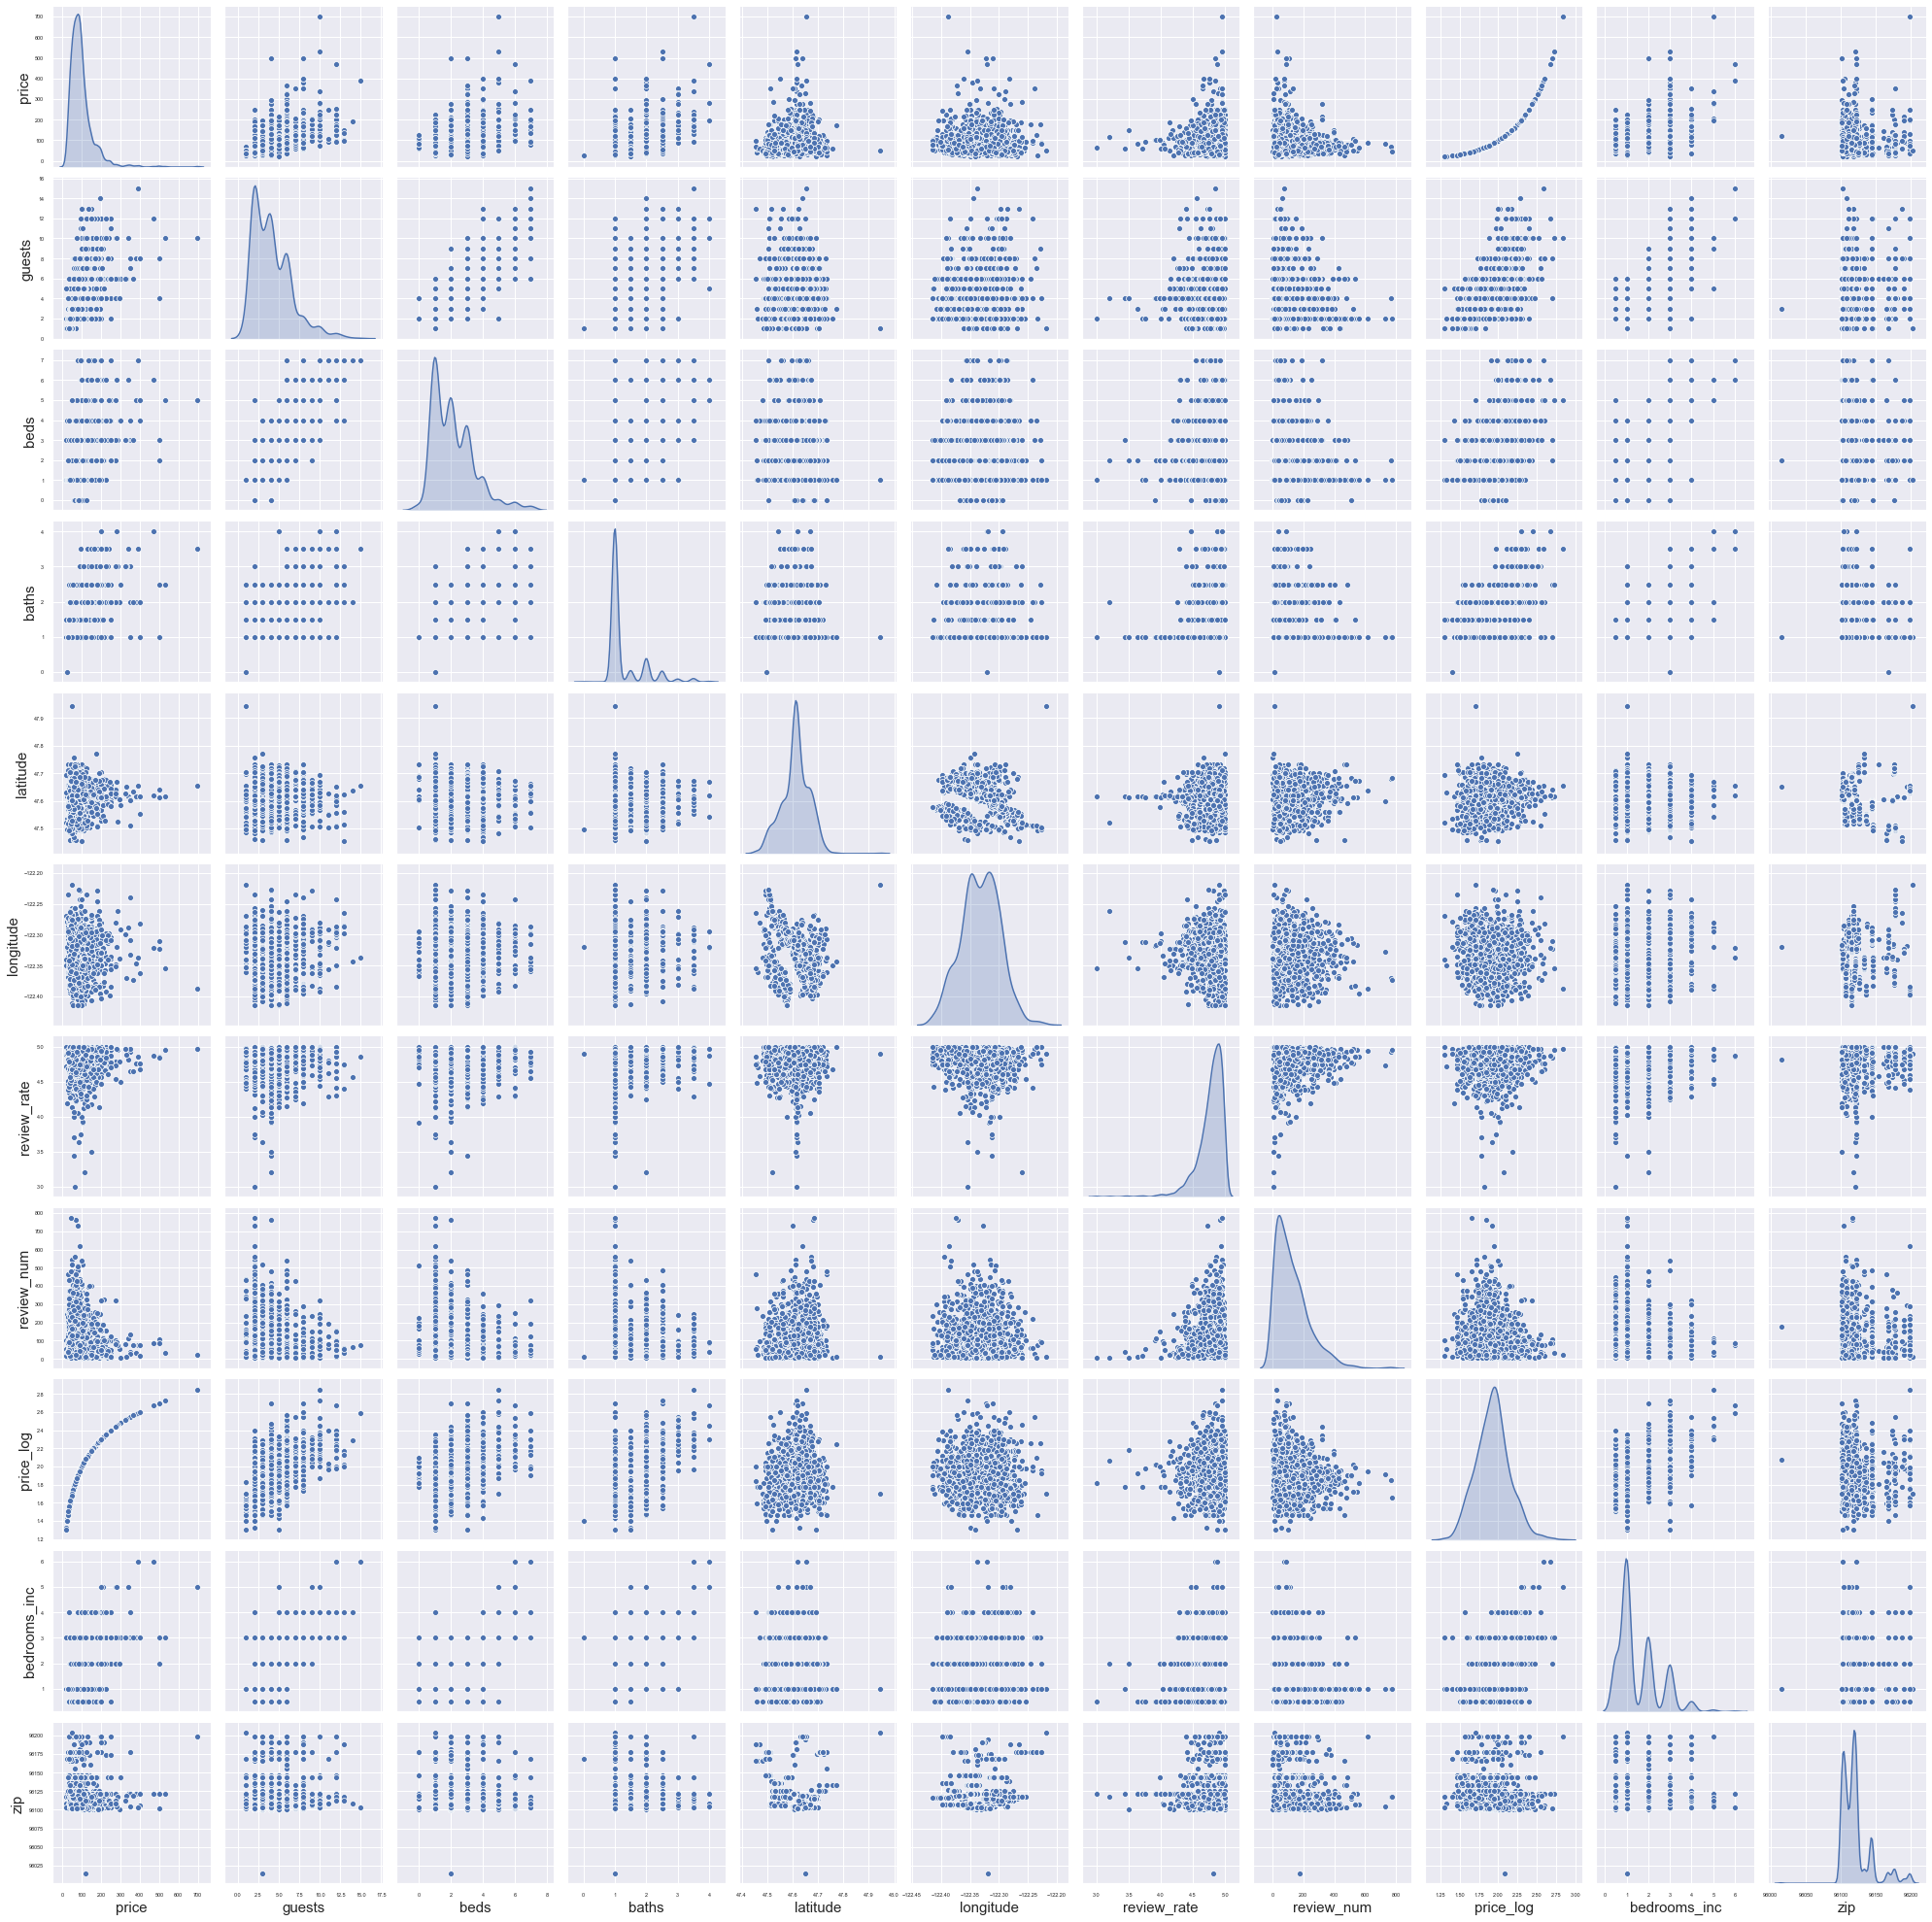

In [72]:
# Plot continuous variables 
sns.pairplot(df2.loc[:,
                 ['price', 'guests', 'bedrooms', 'beds', 'baths', 
                  'latitude', 'longitude', 'review_rate', 'review_num', 
                  'property_type','link', 'price_log', 'bedrooms_inc', 
                  'property_type_inc', 'zip']], 
             diag_kind='kde')
# plt.ylabel('y_test', fontsize=80)

In [ ]:
# Candidates for power transformation (target has been transformed already): 
'zip', 'bedrooms_inc', 'review_num', 'review_rate', 'baths', 'beds', 'guests' 

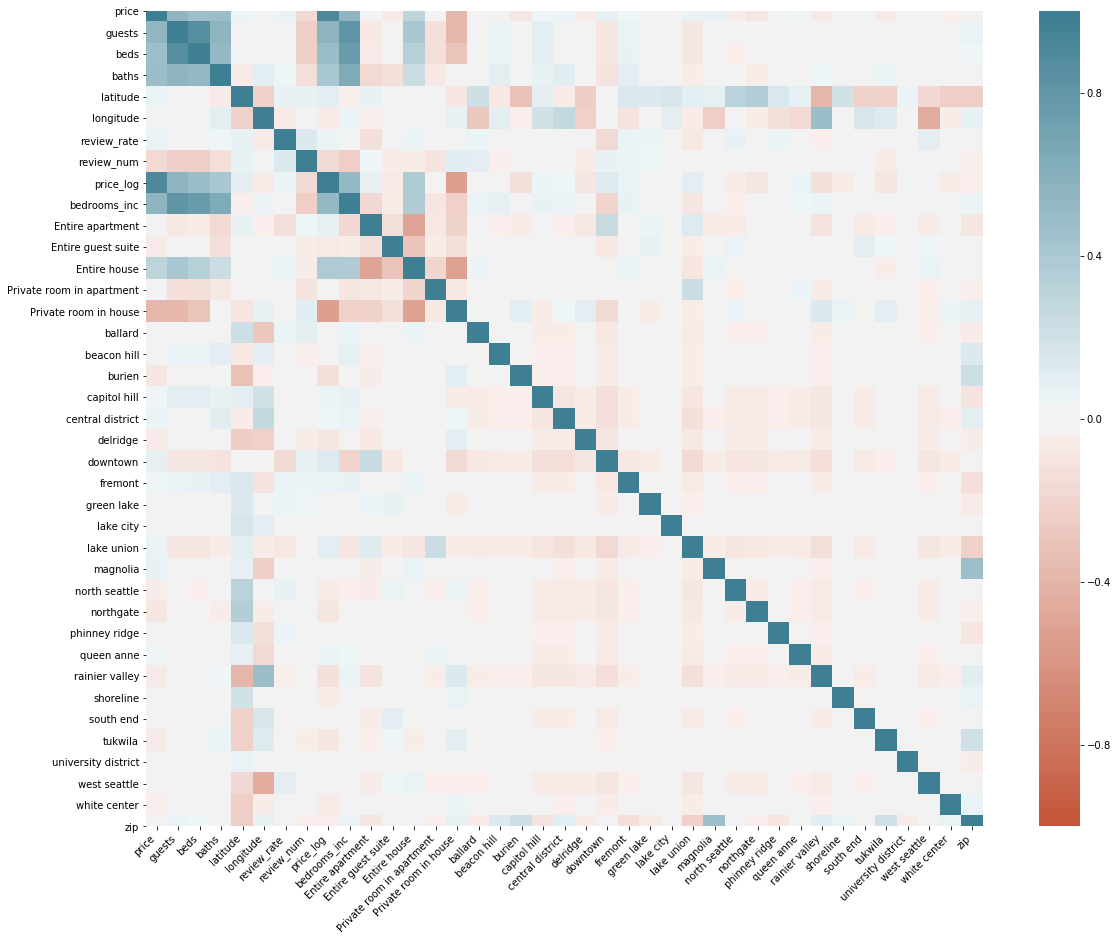

In [488]:
# Correlation matrix
plt.subplots(figsize=(20,15))
hitmap = sns.heatmap(
    df2.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
hitmap.set_xticklabels(
    hitmap.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

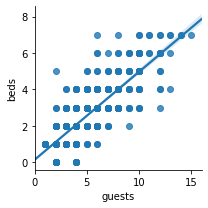

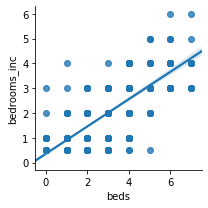

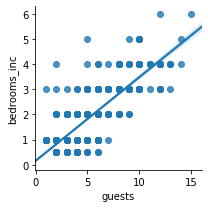

In [102]:
sns.lmplot(x='guests', y='beds', data=df2, size=3)
sns.lmplot(x='beds', y='bedrooms_inc', data=df2, size=3)
sns.lmplot(x='guests', y='bedrooms_inc', data=df2, size=3)

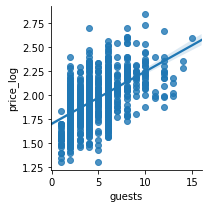

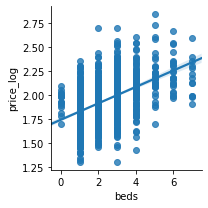

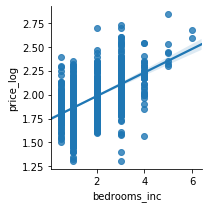

In [105]:
sns.lmplot(x='guests', y='price_log', data=df2, size=3)
sns.lmplot(x='beds', y='price_log', data=df2, size=3)
sns.lmplot(x='bedrooms_inc', y='price_log', data=df2, size=3)

In [ ]:
# Try taking out `beds` to decrease correlation between features. Decreased R2 a bit. Keep it.

## Get dummies

In [27]:
# Get dummies for `property_type_inc`
df2 = pd.concat([df2,pd.get_dummies(df2['property_type_inc'])], axis=1)

In [29]:
df2.shape

(1315, 20)

In [30]:
df2.columns

Index(['property_id', 'price', 'guests', 'bedrooms', 'beds', 'baths',
       'latitude', 'longitude', 'review_rate', 'review_num', 'property_type',
       'link', 'price_log', 'bedrooms_inc', 'property_type_inc',
       'Entire apartment', 'Entire guest suite', 'Entire house',
       'Private room in apartment', 'Private room in house'],
      dtype='object')

In [364]:
df2.shape

(1244, 23)

In [56]:
# Get dummies for `hood`
df2 = pd.concat([df2,pd.get_dummies(df2['hood'])], axis=1)

In [57]:
df2.shape

(1235, 47)

In [58]:
df2.columns

Index(['property_id', 'price', 'guests', 'bedrooms', 'beds', 'baths',
       'latitude', 'longitude', 'review_rate', 'review_num', 'property_type',
       'link', 'price_log', 'bedrooms_inc', 'property_type_inc',
       'Entire apartment', 'Entire guest suite', 'Entire house',
       'Private room in apartment', 'Private room in house', 'coordinates',
       'address', 'hood', 'zip', 'ballard', 'beacon hill', 'burien',
       'capitol hill', 'central district', 'delridge', 'downtown', 'fremont',
       'green lake', 'lake city', 'lake union', 'magnolia', 'north seattle',
       'northgate', 'phinney ridge', 'queen anne', 'rainier valley',
       'shoreline', 'south end', 'tukwila', 'university district',
       'west seattle', 'white center'],
      dtype='object')

In [59]:
# Pickle df2 as df3
with open('df3.pkl', 'wb') as f:
    pickle.dump(df2, f)

## Linear Regression

In [661]:
# Set features and target
X = df2.loc[:, [
    'guests', 
    'baths', 
    'beds',
    'bedrooms_inc',
    'review_rate', 
    'review_num',
    'Entire apartment', 
    'Entire guest suite', 
    'Entire house',
    'Private room in apartment', 
    'Private room in house',
#     'zip',
    'ballard', 'beacon hill', 'burien', 'capitol hill','central district', 'delridge', 'downtown', 'fremont', 
    'green lake','lake city', 'lake union', 'magnolia', 'north seattle', 'northgate','phinney ridge', 
    'queen anne', 'rainier valley', 'shoreline','south end', 'tukwila', 'university district', 'west seattle',
    'white center',
#     'latitude',
#     'longitude'
]]

y = df2['price_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=7, shuffle=True)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

In [676]:
# Train 
classifier = LinearRegression()
classifier.fit(X_train_scaled, y_train)
# R2 for train
R2_train = classifier.score(X_train_scaled, y_train)
print('R2 train: ', R2_train)

# Predict
y_pred = classifier.predict(X_test_scaled)
# R2 for test
residuals = y_test - y_pred
R2_test = r2_score(y_test, y_pred)
print('R2 test: ', R2_test)

R2 train:  0.5910277082214301
R2 test:  0.5222172858955358


In [1]:
# Errors
MAE_log = mean_absolute_error(y_test, y_pred)
MAE = math.pow(10, MAE_log)
print('Mean Absolute Error: ', MAE)

RMSE_log = mean_squared_error(y_test, y_pred)
RMSE = math.pow(10, RMSE_log)
print('Root Mean Square Error: ', RMSE)

NameError: name 'mean_absolute_error' is not defined

In [666]:
y_mean_log = y.mean()
y_mean = math.pow(10, y_mean_log)
y_mean

85.73592008770314

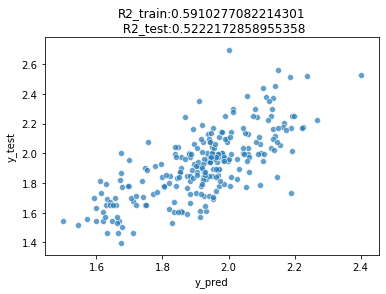

In [667]:
fig = sns.scatterplot(x=y_pred, y=y_test, alpha=.7)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.title('R2_train:' + str(R2_train) + '\n R2_test:'+ str(R2_test))
# plt.savefig('mvp.svg') 
plt.show()

In [668]:
# Explore more complex models

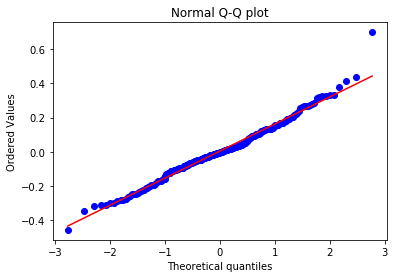

In [671]:
# QQ plot
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q plot");

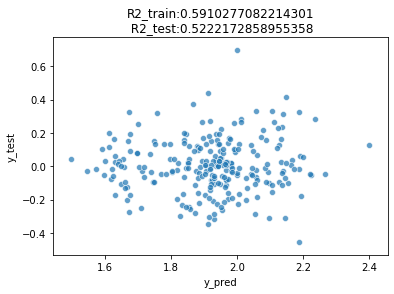

In [670]:
fig = sns.scatterplot(x=y_pred, y=residuals, alpha=.7)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.title('R2_train:' + str(R2_train) + '\n R2_test:'+ str(R2_test))
# plt.plot([[0, 2]], [0, 2])
# plt.savefig('mvp.svg') 
plt.show()

In [3]:
# Assess weather more observations would be benefitial for the improving the model

for d_slice in range(100, 1200,100) in df2:
    X_sampl = df2.loc[:d_slice,:]
    

NameError: name 'df2' is not defined

## Polinomial transformation to increase model complexity

In [600]:
# Feature transformation
scaler = StandardScaler()
tranformer = PolynomialFeatures(degree=2)
pipe = make_pipeline(tranformer, scaler)

X_train_scaled = pipe.fit_transform(X_train.values)
X_test_scaled = pipe.transform(X_test.values)

In [601]:
# Train 
classifier = LinearRegression()
classifier.fit(X_train_scaled, y_train)
# R2 for train
R2_train = classifier.score(X_train_scaled, y_train)
R2_train

0.7440483063863983

In [602]:
# Predict
y_pred = classifier.predict(X_test_scaled)
# R2 for test
R2_test = r2_score(y_test, y_pred)
R2_test

-6.685229717407989e+24

In [603]:
# The model is overfitting train data that results in poor generalization. Explore regularization methods.

## Models with regularization

### Ridge

In [604]:
# Train 
classifier = Ridge()
classifier.fit(X_train_scaled, y_train)
# R2 for train
R2_train = classifier.score(X_train_scaled, y_train)
R2_train

0.7364001904161535

In [605]:
# Predict
y_pred = classifier.predict(X_test_scaled)
# R2 for test
R2_test = r2_score(y_test, y_pred)
R2_test

0.3422883977758132

In [606]:
# 

### Lasso

In [607]:
# Train 
classifier = Lasso()
classifier.fit(X_train_scaled, y_train)
# R2 for train
R2_train = classifier.score(X_train_scaled, y_train)
R2_train

0.0

In [608]:
# Predict
y_pred = classifier.predict(X_test_scaled)
# R2 for test
R2_test = r2_score(y_test, y_pred)
R2_test

-0.002147402018066513

In [609]:
#

### Elasticnet

In [610]:
# Train 
classifier = ElasticNet()
classifier.fit(X_train_scaled, y_train)
# R2 for train
R2_train = classifier.score(X_train_scaled, y_train)
R2_train

0.0

In [611]:
# Predict
y_pred = classifier.predict(X_test_scaled)
# R2 for test
R2_test = r2_score(y_test, y_pred)
R2_test

-0.002147402018066513

In [ ]:
#

### Ridge with correlated features removed

In [636]:
# Set features and target
X = df2.loc[:, [
    'guests', 
    'baths', 
#     'beds',
    'bedrooms_inc',
#     'review_rate', 
#     'review_num',
    'Entire apartment', 
    'Entire guest suite', 
    'Entire house',
    'Private room in apartment', 
    'Private room in house',
#     'zip',
    'ballard', 'beacon hill', 'burien', 'capitol hill','central district', 'delridge', 'downtown', 'fremont', 
    'green lake','lake city', 'lake union', 'magnolia', 'north seattle', 'northgate','phinney ridge', 
    'queen anne', 'rainier valley', 'shoreline','south end', 'tukwila', 'university district', 'west seattle',
    'white center',
#     'latitude',
#     'longitude'
]]

y = df2['price_log']

In [637]:
# Feature transformation
scaler = StandardScaler()
tranformer = PolynomialFeatures(degree=2)
pipe = make_pipeline(tranformer, scaler)

X_train_scaled = pipe.fit_transform(X_train.values)
X_test_scaled = pipe.transform(X_test.values)

In [638]:
# Train 
classifier = Ridge()
classifier.fit(X_train_scaled, y_train)
# R2 for train
R2_train = classifier.score(X_train_scaled, y_train)
R2_train

0.7364001904161535

In [639]:
# Predict
y_pred = classifier.predict(X_test_scaled)
# R2 for test
R2_test = r2_score(y_test, y_pred)
R2_test

0.3422883977758132

In [ ]:
# No differences in R2 were observed after removal of correlated features: `beds`, `guests`, and/or `bedrooms_inc`

In [551]:
# Split data 60 - 20 - 20 train/val/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [552]:
# Set the transformations
poly_transform = make_pipeline(PolynomialFeatures(degree=3), StandardScaler())

mapper = DataFrameMapper([
    (['guests', 
    'baths', 
    'beds',
    'bedrooms_inc',
    'review_rate', 
    'review_num',
    'Entire apartment', 
    'Entire guest suite', 
    'Entire house',
    'Private room in apartment', 
    'Private room in house',
#     'zip',
    'ballard', 'beacon hill', 'burien', 'capitol hill','central district', 'delridge', 'downtown', 'fremont', 
    'green lake','lake city', 'lake union', 'magnolia', 'north seattle', 'northgate','phinney ridge', 
    'queen anne', 'rainier valley', 'shoreline','south end', 'tukwila', 'university district', 'west seattle',
    'white center',], 
     StandardScaler())
])
mapper.fit_transform(X)

array([[ 0.78631465, -0.50751277,  0.637987  , ..., -0.06375767,
         4.17526476, -0.13152258],
       [ 1.65028136,  2.07182166,  0.637987  , ..., -0.06375767,
        -0.23950577, -0.13152258],
       [-0.07765207, -0.50751277, -0.12846625, ..., -0.06375767,
        -0.23950577, -0.13152258],
       ...,
       [-0.94161878, -0.50751277, -0.89491951, ..., -0.06375767,
        -0.23950577, -0.13152258],
       [-0.94161878,  1.21204352, -0.89491951, ..., -0.06375767,
        -0.23950577, -0.13152258],
       [-0.07765207, -0.50751277, -0.12846625, ..., -0.06375767,
        -0.23950577, -0.13152258]])

In [561]:
# Model and cross validation
alphas = 10**np.linspace(-2,2,200)
model = LassoCV(alphas = alphas, cv=5)
pipe = make_pipeline(mapper, model)

In [562]:
# Train 
pipe.fit(X,y)

Pipeline(memory=None,
         steps=[('dataframemapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[(['guests', 'baths', 'beds',
                                             'bedrooms_inc', 'review_rate',
                                             'review_num', 'Entire apartment',
                                             'Entire guest suite',
                                             'Entire house',
                                             'Private room in apartment',
                                             'Private room in house', 'ballard',
                                             'beacon hill', 'burien',
                                             'capitol hill', 'central district',
                                             'delridge', 'downtown'...
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
      

In [570]:
# Scores
LR = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state = 5)
lasso_score = cross_val_score(LR, X, y, cv=kf, scoring='r2').mean()

In [571]:
lasso_score

0.5499338049113947

In [559]:
# Predict
y_pred = pipe.predict(X)

Text(0, 0.5, 'Actual Airbnb rate')

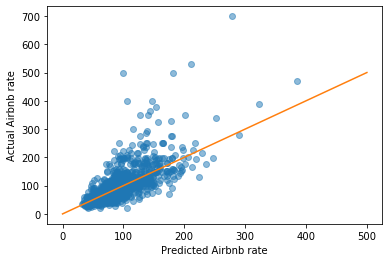

In [560]:
plt.scatter(np.exp(y_pred),np.exp(y),alpha=0.5)

plt.plot([0,500],[0,500],c='C1')
plt.xlabel('Predicted Airbnb rate')
plt.ylabel('Actual Airbnb rate')